In [2]:
import numpy as np
import pandas as pd
import requests
from bs4 import BeautifulSoup
import json
import random
import datetime
import multiprocessing
from collections import defaultdict
import time
import glob
import os
import urllib3
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

urllib3.disable_warnings()

data_path = '{symbol}/{profile|financials|stock|option}/{date}/{time}.csv|.json|.html|.txt'
list_path = 'list/{company|etf}.csv'

In [4]:
CONFIG = json.load(open('/opt/optrade/config.json', 'r'))

def requests_get(url, config=dict()):
    ntry = config.get('ntry', 1)
    verbose = config.get('verbose', False)
    for itry in range(ntry):
        if verbose:
            print(f'get({itry+1}/{ntry}):', url)
        if config.get('headers', None):
            if isinstance(config['headers'], str):
                headers = random.sample(json.load(open(config['headers'], 'r')), 1)[0]
                if verbose:
                    print('sampled one header from:', config['headers'], '->', headers)
            else:
                headers = config['headers']
        else:
            headers = None
        if config.get('proxies', None):
            if isinstance(config['proxies'], str):
                df = pd.read_csv(config['proxies'], dtype=str)
                for fkey, fvalue in config.get('proxies_filter', dict()).items():
                    if fkey in df.columns:
                        df = df[df[fkey].isin(fvalue)]
                for fkey, fvalue in config.get('proxies_filter_range', dict()).items():
                    if fkey in df.columns:
                        df = df[fvalue[0] <= df[fkey].astype(float) <= fvalue[1]]
                if len(df) > 0:
                    irow = random.sample(list(df.index.values), 1)[0]
                    proxies = {
                        'http': 'http://'+df.loc[irow, 'ip']+':'+df.loc[irow, 'port'],
                        # 'https': 'https://'+df.loc[irow, 'ip']+':'+df.loc[irow, 'port'],
                    }
                    if verbose:
                        print('sampled one proxy from:', config['proxies'], len(df), '->', proxies)
                else:
                    print('No proxy meet the requirements:', config['proxies'])
                    proxies = None
            else:
                proxies = config['proxies']
        else:
            proxies = None
        try:
            t0 = time.time()
            res = requests.get(url,
                               headers=headers,
                               proxies=proxies,
                               timeout=config.get('timeout', 30), 
                               allow_redirects=config.get('allow_redirects', False),
                               verify=config.get('verify', True))
            latency = time.time()-t0
            if res.status_code == 200:
                if verbose:
                    print('Success in getting:', url, 'latency:', latency)
                return {'html': res.text, 'latency': latency}
            else:
                if verbose:
                    print(f'Abnormal status code ({res.status_code}) in getting({itry+1}/{ntry}):', url)
        except:
            if verbose:
                print(f'Failed in getting({itry+1}/{ntry}):', url)
        dt = config.get('sleep', 0)
        if config.get('sleep_random', False):
            dt *= random.random()
        time.sleep(dt)


def get_symbol_list():
    fns = sorted(glob.glob(CONFIG['data_root_dir']+'/list/nasdaq_screener_*.csv'))
    if fns:
        df = pd.read_csv(fns[-1])
    return df


def save_data(obj, fn):
    print('saving data to:', fn)
    fdir = os.path.dirname(fn)
    if not os.path.exists(fdir):
        os.makedirs(fdir)
    if fn[-5:].lower() == '.html':
        with open(fn, 'w') as fid:
            fid.write(obj.strip())
    elif fn[-4:].lower() == '.csv':
        obj.to_csv(fn, index=None)
    elif fn[-5:].lower() == '.json':
        with open(fn, 'w') as fid:
            json.dump(obj, fid, indent=2)
    else:
        raise ValueError('Unsupported written file type:', fn)


def fetch_offline_data(data_dir, file_pattern):
    fns = sorted(glob.glob(data_dir+'/'+file_pattern))
    if fns:
        fn = fns[-1]
        # print('Found the latest offline data:', fn)
        if fn[-5:].lower() == '.html':
            with open(fn, 'r') as fid:
                return fid.read()
        elif fn[-4:].lower() == '.csv':
            return pd.read_csv(fn)
        elif fn[-5:].lower() == '.json':
            with open(fn, 'r') as fid:
                return json.load(fid)
        else:
            raise ValueError('Unsupported reading file type:', fn)
    else:
        # print('No offline data:', data_dir, file_pattern)
        return


def get_option(symbol, config, date=None, data_root_dir=None, redo=False):
    url = f'https://finance.yahoo.com/quote/{symbol}/options/'
    if date is None:
        date = datetime.datetime.now().isoformat()[:10]
    if data_root_dir is None:
        data_root_dir = CONFIG['data_root_dir']+'/symbols'
    dfs = dict()
    res = requests_get(url, config)
    if res:
        for option_date, dstr in get_option_dates(res['html']):
            data_dir = f'{data_root_dir}/{symbol}/option/{date}/T{dstr}'
            html = fetch_offline_data(data_dir, '*.html')
            df = fetch_offline_data(data_dir, '*.csv')
            data_version = str(int(time.time()))
            if (html is None) or redo:
                res = requests_get(f'{url}?date={option_date}', config)
                save_data(res['html'], f'{data_dir}/{data_version}.html')
            if (df is None) or redo:
                dfs[dstr] = parse_option_table(res['html'])
                save_data(dfs[dstr], f'{data_dir}/{data_version}.csv')
            else:
                dfs[dstr] = df
    return dfs


def get_option_dates(html):
    soup = BeautifulSoup(html, 'lxml')
    tmp = soup.find('div', {'data-testid': 'options-toolbar'})
    dates = []
    if tmp:
        print(len(tmp.div))
        for d in tmp.find('div', {'role': 'listbox'}).find_all('div', {'role': 'option'}):
            tdate = datetime.datetime(1970, 1, 1) + datetime.timedelta(seconds=int(d["data-value"]))
            dates.append((d["data-value"],
                          tdate.isoformat()[:10]))
    return dates


def parse_option_table(html):
    soup = BeautifulSoup(html, 'lxml')
    tables = soup.find('section', {'data-testid': 'options-list-table'}).findAll('div', class_='tableContainer')
    df1 = defaultdict(list)
    for j, tr in enumerate(tables[0].findAll('tr')):
        if j==0:
            columns = [td.text.strip() for td in tr.findAll('th')]
        else:
            for k, td in enumerate(tr.findAll('td')):
                df1[columns[k]].append(td.text.strip())
    df1 = pd.DataFrame(df1)
    df1['option_type'] = 'call'

    df2 = defaultdict(list)
    for j, tr in enumerate(tables[1].findAll('tr')):
        if j==0:
            columns = [td.text.strip() for td in tr.findAll('th')]
        else:
            for k, td in enumerate(tr.findAll('td')):
                df2[columns[k]].append(td.text.strip())
    df2 = pd.DataFrame(df2)
    df2['option_type'] = 'put'

    return pd.concat([df1, df2], axis=0, ignore_index=True)


def download_onequote(symbol):
    save_dir = f'/home/alice/data/symbols/{symbol}/stock'
    fns = sorted(glob.glob(save_dir+'/*.csv'))
    if fns:
        print('read offline data:', fns[-1])
        df = pd.read_csv(fns[-1])
    else:
        fn = f'{save_dir}/{int(time.time())}.csv'
        print('get online data and save to:', fn)
        url = "https://query1.finance.yahoo.com/v7/finance/chart/" +symbol+ "?&interval=1d&range=40y"
        # url = f'https://query1.finance.yahoo.com/v7/finance/download/{symbol}?period1=864826200&period2=1722642741&interval=1d&events=history&includeAdjustedClose=true'
        obj = requests.get(url, headers=random.choice(json.load(open('../data/headers.json', 'r')))).json()
        result = obj['chart']['result'][0]
        df = dict()
        df['date'] = [(datetime.datetime(1970, 1, 1) + datetime.timedelta(seconds=t)).isoformat()[:10] for t in result['timestamp']]
        for col in list(result['indicators']['quote'][0].keys()):
            df[col] = result['indicators']['quote'][0][col]
        for col in list(result['indicators']['adjclose'][0].keys()):
            df[col] = result['indicators']['adjclose'][0][col]
        df = pd.DataFrame(df)
        save_data(df, fn)
        time.sleep(3)

    print(symbol, df.shape, df.loc[0, 'date'])    
    df['date'] = pd.to_datetime(df['date'])
    return df



In [44]:
list_office = ['ARE', 'BXP', 'VNO', 'SLG', 'CUZ', 'KRC', 'HIW']
list_hotel = ['HST', 'RHP', 'APLE', 'PK', 'SHO', 'DRH', 'PEB']
list_resi = ['AVB', 'EQR', 'INVH', 'ESS', 'MAA', 'SUI', 'AMH', 'UDR', 'CPT', 'ELS', ] #'SZRRF']
# dfs = dict()
for symbol in list_resi:
    dfs[symbol] = download_onequote(symbol)


read offline data: /home/alice/data/symbols/AVB/stock/1722646428.csv
AVB (7652, 7) 1994-03-11
read offline data: /home/alice/data/symbols/EQR/stock/1722646431.csv
EQR (7799, 7) 1993-08-12
read offline data: /home/alice/data/symbols/INVH/stock/1722646435.csv
INVH (1888, 7) 2017-02-01
read offline data: /home/alice/data/symbols/ESS/stock/1722646438.csv
ESS (7593, 7) 1994-06-07
read offline data: /home/alice/data/symbols/MAA/stock/1722646441.csv
MAA (7681, 7) 1994-01-28
read offline data: /home/alice/data/symbols/SUI/stock/1722646444.csv
SUI (7716, 7) 1993-12-09
read offline data: /home/alice/data/symbols/AMH/stock/1722646448.csv
AMH (2770, 7) 2013-08-01
read offline data: /home/alice/data/symbols/UDR/stock/1722646451.csv
UDR (10080, 7) 1984-08-03
read offline data: /home/alice/data/symbols/CPT/stock/1722646454.csv
CPT (7814, 7) 1993-07-22
read offline data: /home/alice/data/symbols/ELS/stock/1722646457.csv
ELS (7916, 7) 1993-02-25


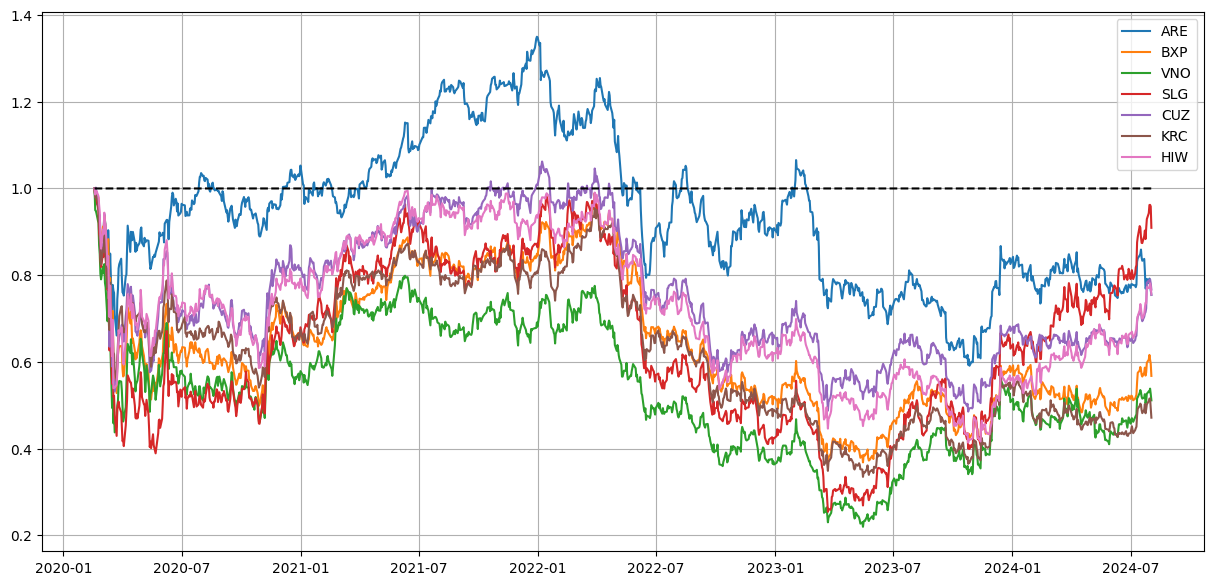

In [39]:

plt.figure(1, figsize=(15, 7))
for s in list_office:
    flag = ('2008-09-01' < dfs[s]['date']) & (dfs[s]['date'] < '2009-12-01')
    flag = ('2020-02-14' < dfs[s]['date'])
    data = dfs[s].loc[flag, 'adjclose'].values
    plt.plot(dfs[s].loc[flag, 'date'], data/data[0])

plt.legend(list_office)
plt.plot(dfs[s].loc[flag, 'date'], [1]*len(data), 'k--')
plt.grid(True)

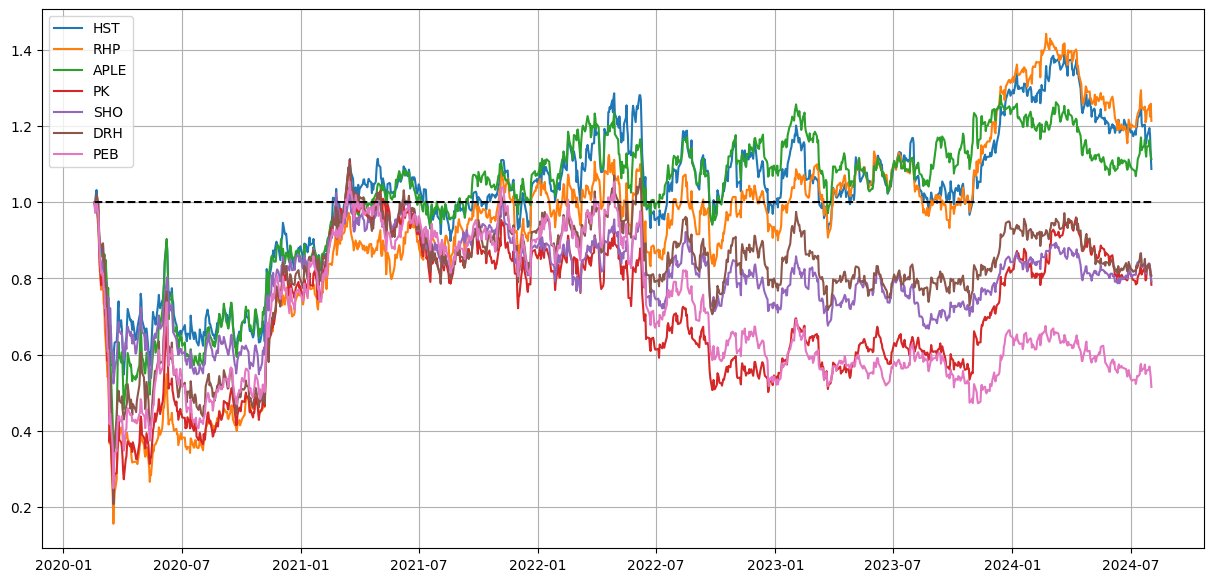

In [41]:

plt.figure(1, figsize=(15, 7))
for s in list_hotel:
    flag = ('2008-09-01' < dfs[s]['date']) & (dfs[s]['date'] < '2009-12-01')
    flag = ('2020-02-14' < dfs[s]['date'])
    data = dfs[s].loc[flag, 'adjclose'].values
    plt.plot(dfs[s].loc[flag, 'date'], data/data[0])

plt.legend(list_hotel)
plt.plot(dfs[s].loc[flag, 'date'], [1]*len(data), 'k--')
plt.grid(True)


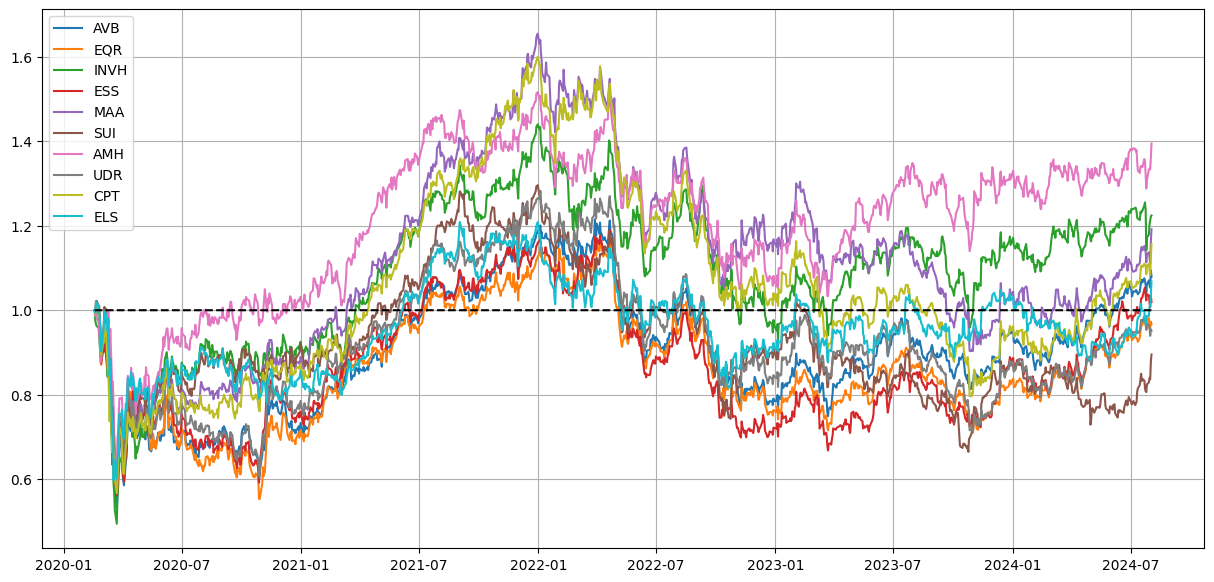

In [45]:

plt.figure(1, figsize=(15, 7))
for s in list_resi:
    flag = ('2008-09-01' < dfs[s]['date']) & (dfs[s]['date'] < '2009-12-01')
    flag = ('2020-02-14' < dfs[s]['date'])
    data = dfs[s].loc[flag, 'adjclose'].values
    plt.plot(dfs[s].loc[flag, 'date'], data/data[0])

plt.legend(list_resi)
plt.plot(dfs[s].loc[flag, 'date'], [1]*len(data), 'k--')
plt.grid(True)


In [7]:
config = {'verbose': False, 'ntry': 1, 'sleep': 2, 'timeout': 10,
          'verify': False, 'allow_redirects': False, 
          'headers': '../data/headers.json'}
dfs = get_option('BSX', config, date=None, data_root_dir='/home/alice/data/symbols', redo=False)


optiontable
Found the latest offline data: /home/alice/data/symbols/BSX/option/2024-07-29/T2024-08-02/1722272994.html
Found the latest offline data: /home/alice/data/symbols/BSX/option/2024-07-29/T2024-08-02/1722273116.csv
Found the latest offline data: /home/alice/data/symbols/BSX/option/2024-07-29/T2024-08-09/1722273116.html
Found the latest offline data: /home/alice/data/symbols/BSX/option/2024-07-29/T2024-08-09/1722273316.csv
Found the latest offline data: /home/alice/data/symbols/BSX/option/2024-07-29/T2024-08-16/1722273316.html
Found the latest offline data: /home/alice/data/symbols/BSX/option/2024-07-29/T2024-08-16/1722273593.csv
Found the latest offline data: /home/alice/data/symbols/BSX/option/2024-07-29/T2024-08-23/1722273593.html
Found the latest offline data: /home/alice/data/symbols/BSX/option/2024-07-29/T2024-08-23/1722273681.csv
Found the latest offline data: /home/alice/data/symbols/BSX/option/2024-07-29/T2024-08-30/1722273681.html
Found the latest offline data: /home/a

In [ ]:
dflist = get_symbol_list()
arglist = [(s, None, None, None, 30, 3, False, 0.5) for s in dflist['Symbol'].values]
with multiprocessing.Pool(processes=16) as pool:
    _ = pool.starmap(get_option, arglist)


In [44]:
dflist = get_symbol_list()
dflist

,Symbol,Name,Last Sale,Net Change,% Change,Market Cap,Country,IPO Year,Volume,Sector,Industry
0,A,Agilent Technologies Inc. Common Stock,$131.78,-0.1900,-0.144%,3.844825e+10,United States,1999.0,1731421,Industrials,Biotechnology: Laboratory Analytical Instruments
1,AA,Alcoa Corporation Common Stock,$34.92,-0.7300,-2.048%,6.270224e+09,United States,2016.0,5335324,Industrials,Aluminum
2,AACG,ATA Creativity Global American Depositary Shares,$0.6507,0.0056,0.868%,2.082248e+07,China,2008.0,153860,Real Estate,Other Consumer Services
3,AACI,Armada Acquisition Corp. I Common Stock,$11.39,-0.0350,-0.306%,0.000000e+00,United States,2021.0,68957,Finance,Blank Checks
4,AACIU,Armada Acquisition Corp. I Unit,$11.93,0.0000,0.00%,0.000000e+00,United States,2021.0,1,Finance,Blank Checks
...,...,...,...,...,...,...,...,...,...,...,...
7070,ZVRA,Zevra Therapeutics Inc. Common Stock,$6.05,-0.3200,-5.024%,2.532136e+08,United States,NaN,545764,Health Care,Biotechnology: Pharmaceutical Preparations
7071,ZVSA,ZyVersa Therapeutics Inc. Common Stock,$3.91,0.0300,0.773%,3.264443e+06,United States,2022.0,54137,Health Care,Biotechnology: Pharmaceutical Preparations
7072,ZWS,Zurn Elkay Water Solutions Corporation Common ...,$30.96,-0.1800,-0.578%,5.346694e+09,United States,2012.0,811297,Industrials,Industrial Machinery/Components
7073,ZYME,Zymeworks Inc. Common Stock,$9.78,-0.0300,-0.306%,6.914938e+08,United States,NaN,597543,Health Care,Biotechnology: Pharmaceutical Preparations


In [39]:
dfs = get_option('BSX')


get: https://finance.yahoo.com/quote/BSX/options/
Found the latest offline data: /home/alice/option_data/BSX/option/2024-07-22/T2024-08-16/1721696975.html
Found the latest offline data: /home/alice/option_data/BSX/option/2024-07-22/T2024-08-16/1721696975.csv
Found the latest offline data: /home/alice/option_data/BSX/option/2024-07-22/T2024-09-20/1721696976.html
Found the latest offline data: /home/alice/option_data/BSX/option/2024-07-22/T2024-09-20/1721696976.csv
Found the latest offline data: /home/alice/option_data/BSX/option/2024-07-22/T2024-11-15/1721696976.html
Found the latest offline data: /home/alice/option_data/BSX/option/2024-07-22/T2024-11-15/1721696976.csv
Found the latest offline data: /home/alice/option_data/BSX/option/2024-07-22/T2025-01-17/1721696977.html
Found the latest offline data: /home/alice/option_data/BSX/option/2024-07-22/T2025-01-17/1721696977.csv
Found the latest offline data: /home/alice/option_data/BSX/option/2024-07-22/T2025-02-21/1721696977.html
Found the

In [40]:
dfs['2024-08-16']

,Contract Name,Last Trade Date (EDT),Strike,Last Price,Bid,Ask,Change,% Change,Volume,Open Interest,Implied Volatility,option_type
0,BSX240816C00042500,6/17/2024 3:51 PM,42.5,34.10,34.60,35.50,0.00,0.00%,-,10,0.00%,call
1,BSX240816C00050000,7/18/2024 5:46 PM,50.0,24.90,26.70,30.30,0.00,0.00%,5,109,95.80%,call
2,BSX240816C00052500,5/15/2024 7:06 PM,52.5,22.51,24.70,25.00,0.00,0.00%,1,12,0.00%,call
3,BSX240816C00055000,7/19/2024 7:45 PM,55.0,22.75,23.40,24.70,0.00,0.00%,1,164,102.83%,call
4,BSX240816C00057500,7/10/2024 7:57 PM,57.5,19.97,19.10,22.40,0.00,0.00%,3,119,115.87%,call
5,BSX240816C00060000,7/2/2024 7:15 PM,60.0,16.93,16.50,20.00,0.00,0.00%,2,607,106.59%,call
6,BSX240816C00062500,7/10/2024 5:00 PM,62.5,14.75,15.80,16.30,0.00,0.00%,1,208,56.15%,call
7,BSX240816C00065000,7/18/2024 1:31 PM,65.0,12.65,12.00,13.80,0.00,0.00%,1,455,56.64%,call
8,BSX240816C00067500,7/19/2024 5:18 PM,67.5,10.32,10.00,13.10,0.00,0.00%,2,780,54.00%,call
9,BSX240816C00070000,7/22/2024 7:22 PM,70.0,9.30,8.70,9.50,1.90,25.68%,4,"1,524",53.15%,call


In [67]:
# url = 'https://www.nasdaq.com/market-activity/stocks/adi/option-chain'
url = 'http://finance.yahoo.com/quote/BSX/options/'
# url = 'http://finance.yahoo.com/'
config = {'verbose': True, 'ntry': 3, 'sleep': 1, 'timeout': 10,
          'verify': False, 'allow_redirects': True, 
          'headers': '../data/headers.json',
          'proxies': '/home/alice/data/proxies/checked.csv',
          'proxies_filter': {'valid': ['True'], }}    
res = requests_get(url, config)
get_option_dates(res['html'])

get(1/3): http://finance.yahoo.com/quote/BSX/options/
sampled one header from: ../data/headers.json -> {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:77.0) Gecko/20100101 Firefox/77.0', 'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8', 'Accept-Language': 'en-US,en;q=0.5', 'Accept-Encoding': 'gzip, deflate, br', 'Referer': 'https://www.google.com/', 'DNT': '1', 'Connection': 'keep-alive', 'Upgrade-Insecure-Requests': '1'}
sampled one proxy from: /home/alice/data/proxies/checked.csv 789 -> {'http': 'http://95.164.113.107:80'}
Success in getting: http://finance.yahoo.com/quote/BSX/options/ latency: 1.528334617614746


[]

In [61]:
get_option_dates(res['html'])

[]

In [37]:
url = 'http://finance.yahoo.com/quote/BSX/options/'
# url = 'https://www.aphanti.com/myip'
headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10.15; rv:77.0) Gecko/20100101 Firefox/77.0', 'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8', 'Accept-Language': 'en-US,en;q=0.5', 'Referer': 'https://www.google.com/', 'DNT': '1', 'Connection': 'keep-alive', 'Upgrade-Insecure-Requests': '1'}
proxies = {'https': 'http://171.237.62.47:10005', 'http': 'http://171.237.62.47:10005'}
res = requests.get(url,
                   headers=headers,
                   proxies=proxies,
                   timeout=10, 
                   allow_redirects=True,
                   verify=False)
print(res.status_code)
print(res.text)
# get_option_dates(res.text)


ReadTimeout: HTTPConnectionPool(host='171.237.62.47', port=10005): Read timed out. (read timeout=10)

In [9]:
get_option_dates(res.text)

[]

In [23]:
df = pd.read_csv('/home/alice/data/proxies/checked.csv')
cols = ['ip', 'port', 'country', 'level', 'https', 'valid', 'checked', 'latency']
df[(df['valid']==True)&(df['https']==True)][cols].sort_values('latency')
# print(df.columns)
# df.loc[df['ip'] == '141.0.11.241', ['ip', 'port', 'country', 'level', 'https', 'valid', 'checked', 'latency']]

,ip,port,country,level,https,valid,checked,latency
6,3.84.86.124,3128,United States,elite,True,True,2024-07-26T19:04:13,0.042182
84,195.189.142.132,80,Netherlands,anonymous,True,True,2024-07-26T19:04:13,0.167154
72,185.26.180.180,80,South Africa,anonymous,True,True,2024-07-26T19:04:13,0.191465
22,35.185.196.38,3128,United States,anonymous,True,True,2024-07-26T19:04:13,0.286201
3,149.51.224.105,3128,Germany,elite,True,True,2024-07-26T19:04:13,0.372993
99,141.0.11.254,80,Unknown,anonymous,True,True,2024-07-26T19:04:13,0.460819
89,141.0.11.243,80,Unknown,anonymous,True,True,2024-07-26T19:04:13,0.474436
63,141.0.11.241,80,Unknown,anonymous,True,True,2024-07-26T19:04:13,0.498278
86,141.0.8.95,80,Unknown,anonymous,True,True,2024-07-26T19:04:13,0.498851
9,135.148.171.194,18080,United States,elite,True,True,2024-07-26T19:04:13,0.585720


In [19]:
df = df.sort_values('latency')
df[df['valid']==True].head(20)


,ip,port,country,level,https,created,alive,alive_since,anonymity,average_timeout,...,protocols,speed,upTime,upTimeSuccessCount,upTimeTryCount,updated_at,isp,responseTime,checked,valid
